In [60]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
import os
from torchvision import datasets, transforms
from torch import optim, nn, unsqueeze
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor, Lambda, Compose
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split


## Model

In [135]:
torch.manual_seed(17)

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset0 = datasets.MNIST('drive/My Drive/mnist/MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.MNIST('drive/My Drive/mnist/MNIST_data/', download=True, train=False, transform=transform)

# Also create a validation set 
trainset, valset = train_test_split(trainset0, test_size=10000, random_state=42)
#pytorch alternative for spliting into train and validation sets
#https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets

batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

In [136]:
class Network(nn.Module):

    def __init__(self):
        super(Network, self).__init__()

        self.conv_neural_network_layers = nn.Sequential(
                # output_sizeOfEachConvLayer = [(in_channel + 2*padding - kernel_size) / stride] + 1

                # We have in_channels=1 because our input is a grayscale image
                nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, stride=1), 
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2), 

                # output of second conv layer
                nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2), 

                # output of third conv layer
                nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2) )

        # Linear layer
        self.linear_layers = nn.Sequential(
                nn.Linear(64*3*3, 10))
                # nn.Linear(16, 10)) # The output is 10 which should match the size of our class


    # Defining the forward pass 
    def forward(self, x):
        x = self.conv_neural_network_layers(x)
        # After we get the output of our convolutional layer we must flatten it or rearrange the output into a vector
        x = torch.flatten(x, 1) # same as x = x.view(x.size(0), -1)
        # Then pass it through the linear layer
        x = self.linear_layers(x)

        return x

model = Network()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


loss_fn = nn.BCEWithLogitsLoss() #CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model’s parameters.

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        y_hot = F.one_hot(y, 10)
        y_hot = torch.zeros(batch_size, 10)
        y_hot[range(y_hot.shape[0]), y]=1      

        X, y_hot = X.to(device), y_hot.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y_hot)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    return loss
            

#We also check the model’s performance against the test dataset to ensure it is learning.

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        y_hot = F.one_hot(y, 10)
        y_hot = torch.zeros(batch_size, 10)
        y_hot[range(y_hot.shape[0]), y]=1      

        X, y_hot = X.to(device), y_hot.to(device)

        # Compute prediction error
        pred = model(X)
        test_loss += loss_fn(pred, y_hot).item()
        correct += (pred.argmax(axis=1) == y_hot.argmax(axis=1)).type(torch.float).sum().item()

    test_loss /= 10000
    correct /= size

    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return test_loss, 100*correct


In [115]:
epochs = 5

mmp_train_loss = []
mmp_loss = []
mmp_acc = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(trainloader, model, loss_fn, optimizer)
    mmp_train_loss.append(train_loss)
    loss, acc = test(valloader, model, loss_fn)
    mmp_loss.append(loss)
    mmp_acc.append(acc)
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.000236 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 99.4%, Avg loss: 0.000331 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.000315 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000320 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000389 

Done!


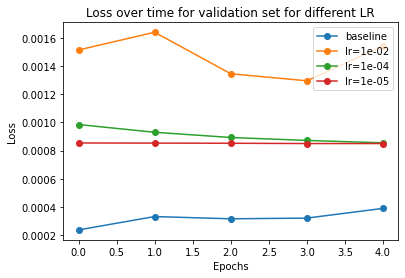

In [130]:
plt.plot(range(5), [0.000236, 0.000331, 0.000315, 0.000320, 0.000389] , '-o', label='baseline')
plt.plot(range(5), [0.001515 , 0.001641, 0.001346, 0.001296, 0.001542 ], '-o',label='lr=1e-02')
plt.plot(range(5), [0.000985 ,  0.000930 , 0.000893, 0.000872, 0.000855], '-o',label='lr=1e-04')
plt.plot(range(5), [0.000854 , 0.000853 ,0.000852 ,0.000850 ,0.000850], '-o',label='lr=1e-05')


plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Loss over time for validation set for different LR')
plt.legend()
plt.savefig('loss_lr.png', dpi=300)

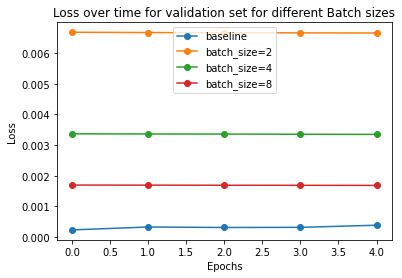

In [129]:
plt.plot(range(5), [0.000236, 0.000331, 0.000315, 0.000320, 0.000389] , '-o', label='baseline')
plt.plot(range(5), [0.006675 ,0.006665 ,0.006661 ,0.006654 ,0.006651], '-o',label='batch_size=2')
plt.plot(range(5), [0.003367 , 0.003361 ,0.003358 ,0.003352 ,0.003348], '-o',label='batch_size=4')
plt.plot(range(5), [0.001697 , 0.001694 ,0.001691 ,0.001689 ,0.001686], '-o',label='batch_size=8')


plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Loss over time for validation set for different Batch sizes')
plt.legend()
plt.savefig('loss_batch_size_val.png', dpi=300)

## Experiments

### Epochs

In [32]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader, model, loss_fn, optimizer)
    test(valloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fdb3a972310>
Traceback (most recent call last):
  File "/Users/brunaguedes/opt/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/Users/brunaguedes/opt/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1295, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


Test Error: 
 Accuracy: 98.4%, Avg loss: 0.000798 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 99.0%, Avg loss: 0.000526 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 98.9%, Avg loss: 0.000572 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 99.0%, Avg loss: 0.000552 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 99.1%, Avg loss: 0.000513 

Done!


In [33]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader, model, loss_fn, optimizer)
    test(valloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 99.1%, Avg loss: 0.000533 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.000476 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 99.1%, Avg loss: 0.000584 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 99.2%, Avg loss: 0.000547 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 99.2%, Avg loss: 0.000596 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 99.2%, Avg loss: 0.000586 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 99.1%, Avg loss: 0.000774 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 99.1%, Avg loss: 0.000723 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 99.1%, Avg loss: 0.000676 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 99.1%, Avg loss: 0.000789 

Done!


### Learning rate

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader, model, loss_fn, optimizer)
    test(valloader, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
Test Error: 
 Accuracy: 97.2%, Avg loss: 0.001515 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 97.5%, Avg loss: 0.001641 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 97.7%, Avg loss: 0.001346 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 97.6%, Avg loss: 0.001296 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 97.4%, Avg loss: 0.001542 

Done!


In [35]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader, model, loss_fn, optimizer)
    test(valloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.000985 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.000930 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 98.4%, Avg loss: 0.000893 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 98.5%, Avg loss: 0.000872 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 98.5%, Avg loss: 0.000855 

Done!


In [36]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader, model, loss_fn, optimizer)
    test(valloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 98.6%, Avg loss: 0.000854 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 98.6%, Avg loss: 0.000853 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 98.6%, Avg loss: 0.000852 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 98.6%, Avg loss: 0.000850 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 98.6%, Avg loss: 0.000850 

Done!


### Mini-batch

In [45]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset0 = datasets.MNIST('drive/My Drive/mnist/MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.MNIST('drive/My Drive/mnist/MNIST_data/', download=True, train=False, transform=transform)

# Also create a validation set 
trainset, valset = train_test_split(trainset0, test_size=10000, random_state=42)
#pytorch alternative for spliting into train and validation sets
#https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets

batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

In [38]:
# batch_size = 8
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader, model, loss_fn, optimizer)
    test(valloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 98.6%, Avg loss: 0.001697 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 98.6%, Avg loss: 0.001694 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 98.6%, Avg loss: 0.001691 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 98.6%, Avg loss: 0.001689 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 98.6%, Avg loss: 0.001686 

Done!


In [40]:
# batch_size = 4
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader, model, loss_fn, optimizer)
    test(valloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 98.6%, Avg loss: 0.003367 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 98.6%, Avg loss: 0.003361 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 98.6%, Avg loss: 0.003358 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 98.6%, Avg loss: 0.003352 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 98.6%, Avg loss: 0.003348 

Done!


In [44]:
# batch_size = 2
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader, model, loss_fn, optimizer)
    test(valloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 98.7%, Avg loss: 0.006675 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 98.7%, Avg loss: 0.006665 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 98.6%, Avg loss: 0.006661 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 98.7%, Avg loss: 0.006654 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 98.7%, Avg loss: 0.006651 

Done!


## Now we choose final model, run the test set!
Choice: epochs = 5, batch_size = 16, learning_rate = 1e-3

In [137]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 5

mmp_train_loss = []
mmp_loss = []
mmp_acc = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(trainloader, model, loss_fn, optimizer)
    mmp_train_loss.append(train_loss)
    loss, acc = test(testloader, model, loss_fn)
    mmp_loss.append(loss)
    mmp_acc.append(acc)
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.000787 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 99.0%, Avg loss: 0.000530 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 99.1%, Avg loss: 0.000493 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 99.1%, Avg loss: 0.000493 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 99.2%, Avg loss: 0.000415 

Done!


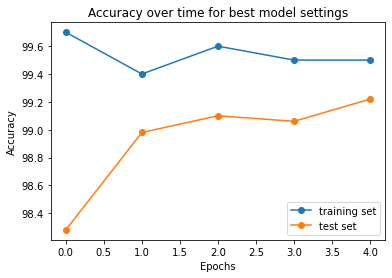

In [145]:
plt.plot(range(5),  [99.7, 99.4, 99.6, 99.5, 99.5], '-o', label='training set')
plt.plot(range(5), [98.28, 98.98, 99.1, 99.06, 99.22], '-o',label='test set')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Accuracy over time for best model settings')
plt.legend()
plt.savefig('acc_best_model_test_set.png', dpi=300)

In [46]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader, model, loss_fn, optimizer)
    test(testloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 98.8%, Avg loss: 0.000703 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 98.9%, Avg loss: 0.000691 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 98.9%, Avg loss: 0.000732 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 98.9%, Avg loss: 0.000774 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 98.9%, Avg loss: 0.000786 

Done!


# Q9

Question 9: Add some data augmentations to the data loader for the training set. Why do we only augment the training data? Play around with the augmentations available in torchvision. Try to get better performance than the baseline. Once you are happy with your choice of augmentations, run both the baseline and the augmented version on the test set and report the accuracies in your report.

Notes:
- When we use data augmentation, loading the whole data into memory creates a problem. If we use the dataloader, then the data augmentation is randomly applied each time. If we preload the data the dataloader only applies sthe data augmentation once, defeating the purpose. Here, we'll need to use pytorch's random split function instead:
https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split

- Apply this to the dataset object before passing it to the dataloader.

In [147]:
# Define a transform to normalize the data (previosly used and now only for val and test)
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))])

# with data augmentation for training only
train_transform = transforms.Compose([transforms.ToTensor(),
                                    # transforms.ToPILImage(),
                                    # transforms.CenterCrop(21),
                                    transforms.RandomRotation(30),
                                    transforms.ColorJitter(brightness=0.2, contrast=0.2),
                                    # transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
                                    transforms.Normalize((0.5,), (0.5,))])


# Download and load the training data
trainset0 = datasets.MNIST('drive/My Drive/mnist/MNIST_data/', download=True, train=True, transform=train_transform)
testset = datasets.MNIST('drive/My Drive/mnist/MNIST_data/', download=True, train=False, transform=transform)

# Also create a validation set 
trainset_augm, valset_augm = random_split(trainset0, [50000, 10000], generator=torch.Generator().manual_seed(42))
# trainset, valset = train_test_split(trainset0, test_size=10000, random_state=42)

batch_size = 16

trainloader_augm = torch.utils.data.DataLoader(trainset_augm, batch_size=batch_size, shuffle=True, num_workers=2)
valloader_augm = torch.utils.data.DataLoader(valset_augm, batch_size=batch_size, shuffle=True, num_workers=2)
testloader_augm = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

In [112]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader_augm, model, loss_fn, optimizer)
    test(valloader_augm, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 98.7%, Avg loss: 0.000683 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 98.8%, Avg loss: 0.000655 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 98.6%, Avg loss: 0.000608 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 98.9%, Avg loss: 0.000604 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 98.7%, Avg loss: 0.000621 

Done!


## Test set for best accuracy in validation

Combination of 
- transforms.RandomRotation(30),
- transforms.ColorJitter(brightness=0.2, contrast=0.2),
- transforms.Normalize((0.5,), (0.5,)

also tried but had worse results:
- adding to the previous transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1))
    - Epoch 5, Test Error: Accuracy: 97.3%, Avg loss: 0.001223 

In [114]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader_augm, model, loss_fn, optimizer)
    test(testloader_augm, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 99.2%, Avg loss: 0.000371 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.000357 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.000391 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 99.4%, Avg loss: 0.000360 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.000367 

Done!


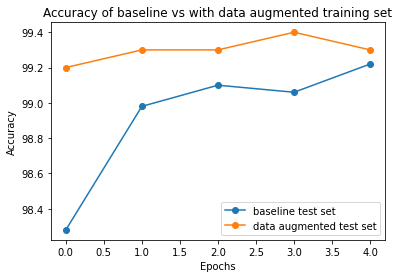

In [152]:
plt.plot(range(5), [98.28, 98.98, 99.1, 99.06, 99.22], '-o',label='baseline test set')
plt.plot(range(5), [99.2, 99.3, 99.3, 99.4, 99.3], '-o',label='data augmented test set')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Accuracy of baseline vs with data augmented training set')
plt.legend()
plt.savefig('data_augmentation.png', dpi=300)